In [44]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np

import warnings
warnings.filterwarnings("ignore")


bottle_filter = 512
final_filter = 16
num_classes = 2
output_channels = 1

In [45]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation='gelu')(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

In [46]:
def transformer_encoder(x, cf):
    skip_1 = x
    x =  LayerNormalization()(x)
    x =  MultiHeadAttention(num_heads = cf["num_heads"],
                            key_dim = cf["hidden_dim"]
                            )(x,x)
    x =  Add()([x, skip_1])
    
    skip_2 = x
    x =  LayerNormalization()(x)
    x =  mlp(x, cf)
    x =  Add()([x, skip_2])

    return x


In [47]:
#this defines the convolutions process involved in the decoder
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #next block
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [48]:
# create a number of decoder blocks
def decoder_block(inputs, skip_features, num_filters):

    #first layer of each decoder block is a 2D-Conv transpose layer of shape 2,2
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x, num_filters)
    return x

In [49]:
def ResNet50ViT(cf):
    #defining the input layer
    inputs =  Input((cf["image_size"],cf["image_size"], cf["num_channels"]))
    #print(inputs.shape)
    #pretrained resnet 50

    resnet50 =  ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    #freeze the base resnet layer
    resnet50.trainable = False
    output = resnet50.get_layer('conv4_block4_out').output  #(None, 14, 14, 1024)
    #print(output.shape)
    #print(resnet50.summary())

    # definng the skip connections for the decoder block to be used later on
    s1 = resnet50.get_layer('conv1_relu').output    #224
    s2 = resnet50.get_layer('conv2_block3_out').output  #112
    s3 = resnet50.get_layer('conv3_block4_out').output  #56

    #print(s1.shape)
    #print(s2.shape)
    #print(s3.shape)

    #creating patch embeddings for the transformer block
    patch_embed = Conv2D(cf["hidden_dim"],
                         kernel_size = cf["patch_size"],
                         padding = 'same'
                         )(output)
    
    #print(patch_embed.shape)
    _, h, w, f = patch_embed.shape
    patch_embed = Reshape((h*w,f))(patch_embed)
    print(patch_embed.shape)

    #position embedings
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    #print(positions)

    pos_embed = Embedding(input_dim = cf ["num_patches"], output_dim = cf["hidden_dim"])(positions)
    print(pos_embed.shape)

    #path + position embedding
    embed = patch_embed + pos_embed
    #print(embed.shape)

    #class embedding has been skipped for this implementation
    x = embed

    #Adding the transformer encoder
    #as the transformer encoder is repeated for 12 times

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x,cf)

    #print(x.shape)
    # reshaping the output of the transformer encoder
    _, hw, f = patch_embed.shape
    _, xdim, ydim, _ = output.shape

    x =  Reshape((hw//xdim,hw//ydim,f))(x)

    # the bottleneck convolution layer
    x = Conv2D(bottle_filter, 3, padding='same')(x)   # this gives the starting path of the upsampling layers
    #print(x.shape)


    #creating a decoder block
    d1 =  decoder_block(x, s3, 224)        #64
    d2 =  decoder_block(d1, s2, 112)        #128
    d3 =  decoder_block(d2, s1, 56)        #256
    #print(d3.shape)

    #the 2nd last layer is an upsampling layer with a 16 filter number, the input for the upsampling

    x = Conv2DTranspose(final_filter, (2,2), strides=2, padding='same')(d3)
    #print(x.shape)

    # A segmentation head is then attached to the final layer to generate the mask
    outputs = Conv2D(output_channels, 1, padding='same', activation='sigmoid')(x)

    #building the final model
    model = model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

    #print(outputs.shape)
    
    

In [50]:
if __name__ == '__main__':
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768 #changed from 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1

    config["image_size"] = 224
    config["patch_size"] = 16
    config["num_patches"] = int(config["image_size"]**2 / config["patch_size"]**2)
    config["num_channels"] = 3
    #config["num_classes"] = num_classes   #changed from 10

    model = ResNet50ViT(config)
    #model.summary()


(None, 196, 768)
(196, 768)


In [51]:
#tf.keras.utils.plot_model(model, to_file='build_model.jpg', show_shapes=False)

### Data Processing and Ready for training

In [52]:
import numpy as np
import os
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
import platform
from sklearn.model_selection import train_test_split as tts

image_size = 224

Load Images

In [53]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [54]:
root_path = './Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes = classes[1:]
classes

['benign', 'malignant', 'normal']

In [55]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

#create a df of paths ands masks
ipdict = {'images':image_paths, 'masks':mask_paths}
data = pd.DataFrame(ipdict)
traind, testd = tts(data, test_size=0.1, random_state=123) 

#creating trainign and testing datas
train_images = load_images(list(traind['images']), image_size)
train_mask = load_images(list(traind['masks']), image_size,  mask=True)

test_images = load_images(list(testd['images']), image_size)
test_mask = load_images(list(testd['masks']), image_size,  mask=True)

Callbacks and Checkpoint

In [56]:
cbs = [
    tf.keras.callbacks.ModelCheckpoint("checkpoint/transunet_intermediate.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='IoU', mode='max' ,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('checkpoint/logs.csv', separator= ',',append=True)
  ]

In [57]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    name="SGD",
    decay = 0.00001
    )
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy',MeanIoU(num_classes=num_classes, name='IoU')])
results = model.fit(train_images, train_mask, validation_split=0.2, batch_size=32, epochs=5)
model.save('checkpoint/tranunet_final1.h5')

Epoch 1/5
18/18 [==============================] - 1955s 109s/step - loss: 0.5019 - accuracy: 0.7716 - IoU: 0.4628 - val_loss: 0.2983 - val_accuracy: 0.9180 - val_IoU: 0.4601
Epoch 2/5
18/18 [==============================] - 1935s 108s/step - loss: 0.2400 - accuracy: 0.9234 - IoU: 0.4628 - val_loss: 0.3537 - val_accuracy: 0.9180 - val_IoU: 0.4601
Epoch 3/5
18/18 [==============================] - 1952s 109s/step - loss: 0.2256 - accuracy: 0.9234 - IoU: 0.4628 - val_loss: 0.3743 - val_accuracy: 0.9180 - val_IoU: 0.4601
Epoch 4/5
18/18 [==============================] - 1978s 110s/step - loss: 0.2216 - accuracy: 0.9234 - IoU: 0.4628 - val_loss: 0.3669 - val_accuracy: 0.9180 - val_IoU: 0.4601
Epoch 5/5
18/18 [==============================] - 2007s 111s/step - loss: 0.2202 - accuracy: 0.9234 - IoU: 0.4628 - val_loss: 0.3496 - val_accuracy: 0.9180 - val_IoU: 0.4601


Plot some graphs

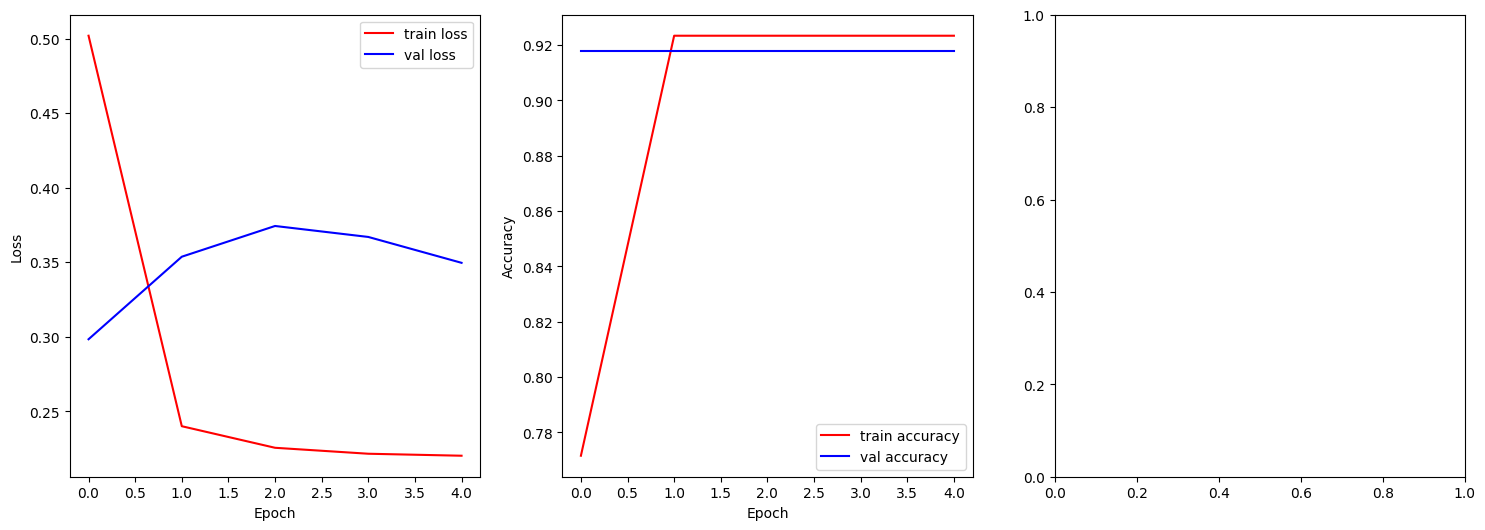

In [59]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)
ax[0].plot(results.history["loss"], c="r", label="train loss")
ax[0].plot(results.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(results.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(results.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

Predicting on a Sample Image

1/1 [==============================] - 1s 1s/step


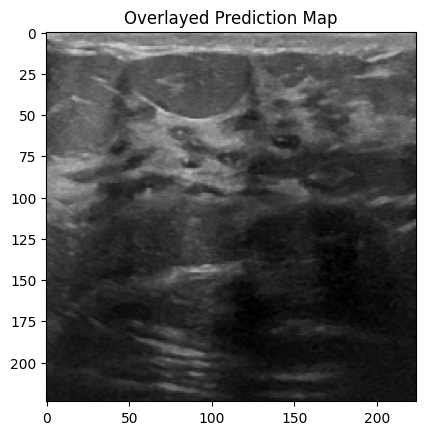

In [77]:
import cv2
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np

r = random.randint(0, len(list(testd['images'])))
read_img = list(testd['images'])[r]

# load the image file
img = load_img(read_img, target_size=(224, 224))

# convert the image to a NumPy array
img_array = img_to_array(img)

# expand the dimensions of the array to match the expected input shape of the Keras model
input_data = np.expand_dims(img_array, axis=0)

# pass the input data to the Keras model for prediction
prediction = model.predict(input_data)
pred_image = prediction[0, :, :, 0]
pred_image_pil = Image.fromarray(pred_image)


plt.imshow(img, cmap='gray')
plt.imshow(pred_image_pil, alpha=0.2)
plt.title('Overlayed Prediction Map')
plt.show()
